# Анализ данных в задаче кредитного скоринга
Review criteria: 
1. Выполнение каждого пункта задания должно начинаться с графика с данными, которые вы собираетесь анализировать. Еще лучше, если вы разложите графики анализируемого фактора по переменной (default), на которую хотите изучить влияние этого фактора, и проинтерпретируете отличия в полученных распределениях.
+ При использовании статистических критериев необходимо убедиться в том, что условия их применимости выполняются. Например, если вы видите, что данные бинарные, то не нужно применять критерий Стьюдента.
+ При каждом использовании любого критерия необходимо указать, какая проверяется гипотеза, против какой альтернативы, чему равен достигаемый уровень значимости, принимается или отвергается нулевая гипотеза на уровне значимости 0.05. Если задача позволяет, нужно оценить размер эффекта и предположить, имеет ли этот результат практическую значимость.
+ Выполненное задание необходимо представить в ipython-ноутбука.

In [111]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from scipy import stats
import scipy
import seaborn as sns
from scipy.stats import chi2_contingency

In [112]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Evtisov_SS\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [113]:
df = pd.read_csv('credit_card_default_analysis.csv')
print (df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

## Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
* a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
* b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

### 1.1 Резюме
1. Данные в выборках вещественные
+ Из графиков видно, распределения признака в выборках немного отличаются
+ Строим интервальную оценку разности медиан на основе бутстрепа.
+ Получаем доверительный интервал = [-70000 -60000]. Доверительный интервал не содержит 0, похоже кредитный лимит влияет на возврат кредита.
+ Данные в выборках независимы, поэтому нужен непараметрический критерий для независимых выборок. Применим перестановочный двувыборочный критерий для независимые выборок. Он не требуетс никаких предусловий. 
+ Проверим равенство распределений с помощью перестановочного двувыборочного критерия для независимые выборок
    * $H_0$ - Распределения в выборках совпадают. Т.е. кредитный лимит не влияет на возврат.
    * $H_1$ - распределения отличаются. Т.е. возврат кредита зависит от кредитного лимита
+ Получим p-value =  0.001000. Следовательно Гипотеза $H_0$ отвергается на ур. значимости 0.05

**Вывод (практическая значимость)**: Кредитный лимит **влияет** на возврат кредита
    

### 1.2. Визуализация

C:\Users\Evtisov_SS\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


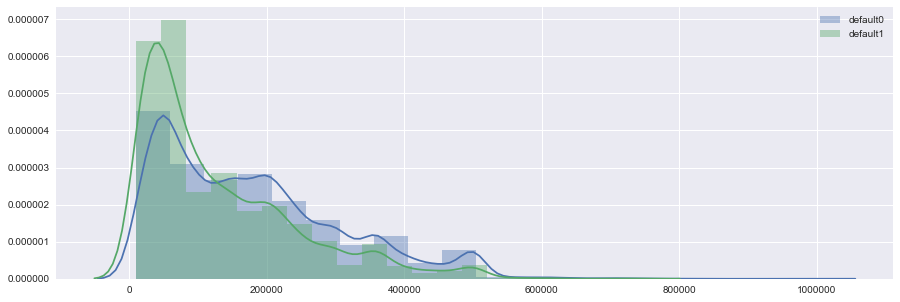

In [114]:
limitbal0=df[df.default==0]['LIMIT_BAL'].values
limitbal1=df[df.default==1]['LIMIT_BAL'].values

n_bins = 20
plt.figure(figsize=[15,5])
sns.distplot(limitbal0,n_bins,label="default0")
sns.distplot(limitbal1,n_bins,label="default1")
plt.legend()
plt.show()

### 1.2. Интервальная оценка разности медиан на основе бутстрепа

In [115]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [116]:
np.random.seed(0)
# Получаем данные
# Формируем при помощт бутстрепа 1000 выборок 
n_boot=1000
limitbal0_median_scores = list(map(np.median, get_bootstrap_samples(limitbal0, n_boot)))
limitbal1_median_scores = list(map(np.median, get_bootstrap_samples(limitbal1, n_boot)))
# Интервальная оценка разности медиан
delta_median_scores = list(map(lambda x: x[1] - x[0], list(zip(limitbal0_median_scores, limitbal1_median_scores))))
print( "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-70000. -60000.]


### 1.2  Перестановочный двувыборочный критерий для независимых выборок

In [117]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    print (n1,n2)
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [118]:
print ("p-value: %f" % permutation_test(limitbal0, limitbal1, max_permutations =  1000))

23364 6636
p-value: 0.001000


## Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

### 2.1 Резюме
1. Данные в выборках бинарные
+ Из графиков видно, что женщин в выборках всегда больше, но как это влияет на возврат кредита не понятно 
+ Поскольку данные в выборках бинарные построим доверительный интервал на разность двух долей
+ Получили доверительный интервал = [0.033635, 0.060548]
+ Доверительный интервал не содержит 0, похоже пол влияет на возврат кредита
+ Выборки не связанные и бинарные. Используем Z критерий для двух долей (несвязанные выборки) по двусторонней альтернативе (он не требует дополнительных предусловий)
    * Нулевая гипотеза - распределение пола одинаковое в двух выборках
    * Альтернатива - распределение пола различается
+ Получили p-value = 4.47287e-12. Следовательно Гипотеза $H_0$ отвергается на ур. значимости 0.05

Вывод: Гендерный состав группы людей вернувших и не вернувших кредит отличается. Пол **влияет** на возврат кредита
    

In [119]:
# Формируем выборки по полу
df_default0=df[df.default==0]['SEX']
df_default1=df[df.default==1]['SEX']
# Бинаризируем значения
# 0 - мужской
# 1 - женский
df_default0=df_default0-1
df_default1=df_default1-1

### 2.2 Визуализация
Построим гистограмы распределения признака в двух выборках

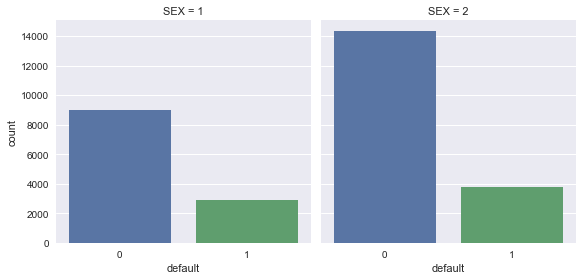

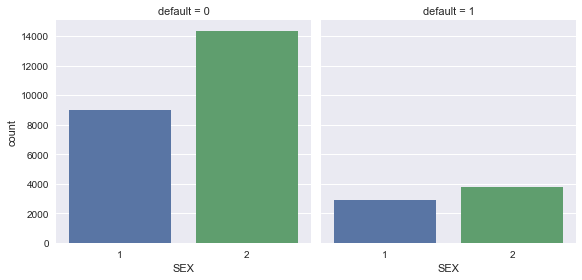

In [120]:
sns.factorplot(x="default",col="SEX", data=df,kind="count")
sns.factorplot(x="SEX",col="default", data=df,kind="count")
plt.show()

### 2.2 Доверительный интервал для разности долей (независимые выборки)

In [121]:
# Расчет доверительного интервала для разности двух долей
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.) 
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    return (left_boundary, right_boundary)
print ("confidence interval: [%f, %f]" % proportions_diff_confint_ind(df_default0, df_default1))

confidence interval: [0.033635, 0.060548]


### 2.3 Z критерий для двух долей
Поскольку данные бинарные, то применим Z критерий для двух долей (выборки не связанные)

Гипотеза $H_0$ проверяет $p_0$=$p_1$, где $p_i$ - вероятность появления единицы в выборке.
Т.е. $H_0$  - гипотеза, что в 2х выборках (вернули/ не вернули кредит) распределение пола одинаковое. Другими словали, если $H_0$ верна, то пол не влияет на возврат кредита


In [122]:
# Z статистика
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
# p-value
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized should be 'two-sided', 'less' or 'greater'")
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)
    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [123]:
z_stat = proportions_diff_z_stat_ind(df_default0, df_default1)
p_value=proportions_diff_z_test(z_stat,"two-sided")
print ("z-stat: %g, p-value: %g" % (z_stat,p_value))

z-stat: 6.92138, p-value: 4.47287e-12


## Задача 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

### 3.1 Резюме

1. Данные категориальные, построим таблицу сопряженности
2. Проверим применимость критерия хи - квадрат. Критерий хи-квадрат для таблиц сопряженности может применяться при выполнении следующих условий. Нужно, чтобы выборки были достаточно большими: n ≥ 40. Кроме того, необходимо, чтобы ожидаемое количество элементов в каждой ячейке таблицы было меньше 5 ( ni+n+j n < 5), не более, чем в 20% ячеек.
    * n=30000 > 40
    * количество ячеек < 5 - меньше 20 % 
+ Следовательно критерий хи квадрат применим. 
    * $H_0$ - выборки независимы
    * $H_1$ - есть зависимости
+  p-value = 1.2332626245415605e-32
+ Гипотеза $H_0$ отвергается на уровне доверия 0.05.
+ Образование должно влиять на возврат кредита
+ С помощью хи-квадрат вычислим ожидаемые значения
+ Вычислим таблицу сопряженности разности между наблюдаемыми и ожидаемыми значениями
+ Вычислим таблицу сопряженности разности между наблюдаемыми и ожидаемыми значениями, предварительно нормализовав данные
+ Наилучший индикатор, что человек отдаст долг = 1 Магистр 
+ Наилучший индикатор, что человек не отдаст долг = 2 Бакалавр 

### 3.2 Визуализация

In [124]:
# Формируем выборки по образованию
df_default0=df[df.default==0]['EDUCATION']
df_default1=df[df.default==1]['EDUCATION']

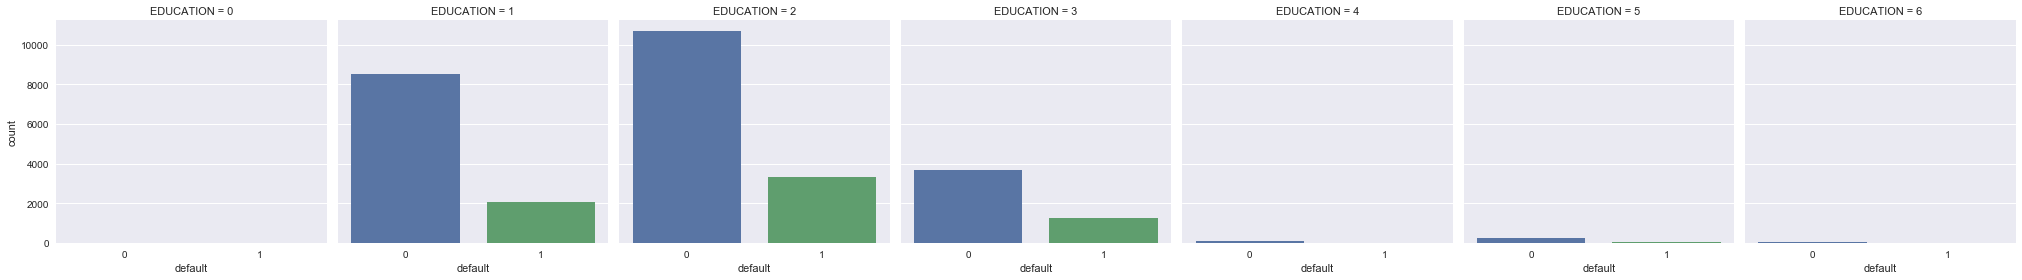

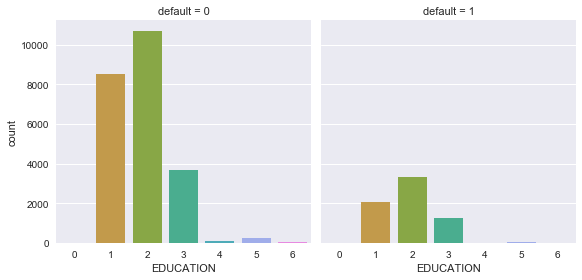

In [125]:
sns.factorplot(x="default",col="EDUCATION", data=df,kind="count")
sns.factorplot(x="EDUCATION",col="default", data=df,kind="count")
plt.show()

### 3.3 Таблица сопряженности

In [138]:
edu=pd.pivot_table(df, values='ID', index=['default'],columns=['EDUCATION'], aggfunc=len)
edu.loc[1,0]=0
edu

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14.0,8549.0,10700.0,3680.0,116.0,262.0,43.0
1,0.0,2036.0,3330.0,1237.0,7.0,18.0,8.0


### 3.4 Проверим применимость критерия хи квадрат


In [155]:
# Объем выборки
edu.sum().sum()

30000.0

In [161]:
# Количество ячеек <5 в наблюдаемых значениях 
(edu<5).sum().sum()/edu.count().sum()

0.07142857142857142

In [173]:
expected.()

30000.000000000007

In [175]:
# Количество ячеек <5 в ожидаемых значениях 
chi,p,dof,expected=chi2_contingency(edu)
(expected<5).sum()/edu.count().sum()

0.071428571428571425

**Критерий хи квадрат применим**

$H_0$ - выборки независимы

$H_1$ - есть зависимости

In [177]:
p

1.2332626245415605e-32

* Гипотеза $H_0$ отвергается на уровне доверия 0.05
* Образование должно влиять на возврат кредита

### 3.5 Таблица сопряженности различий между ожидаемыми и наблюдаемым значениями

In [176]:
edu=edu-expected
edu

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
1,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


### 3.6 Нормализация данных

In [127]:
edu_normalized=pd.pivot_table(df, values='ID', index=['default'],columns=['EDUCATION'], aggfunc=len)
edu_normalized.loc[1,0]=0
edu_min=np.min(edu_normalized.values)
edu_max=np.max(edu_normalized.values)
normalized = lambda x: (x-edu_min)/(edu_max-edu_min)
edu_normalized=edu_normalized.apply(normalized)
# Считаем ожидаемые значения
chi,p,dof,expected=chi2_contingency(edu_normalized)
edu_normalized=edu_normalized-expected
edu_normalized

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,0.000289,0.028542,-0.021174,-0.013959,0.001889,0.004106,0.000307
1,-0.000289,-0.028542,0.021174,0.013959,-0.001889,-0.004106,-0.000307


In [128]:
edu_normalized.loc[0].rank().sort_values().index

Int64Index([2, 3, 0, 6, 4, 5, 1], dtype='int64', name='EDUCATION')

## Задача 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

### 4.1 Резюме
1. В задаче рассматривается 2 признака
    * MARRIAGE: 0,1,2,3
    * default: 0,1        
+ Оба признака категориальные. Посчитаем критерий хи квадрат и коэффициента V Крамера.
+ Проверим применимость критерия Хи квадрат. Он применим.
3. Применим критерий хи квадрат, для категориальных признаков он проверяет гипотезу о равенстве нулю коэффициента V Крамера против альтернативы, что он нулю не равен
    * $H_0$ - коэффициента V Крамера равен нулю т.е. признаки не связаны вообще.
    * $H_1$ - коэффициента V Крамера не равен нулю, т.е. между признаками есть какая-то связь
4. Получаем p-value=8.8258624575773752e-08
5. Посчитаем коэффициент V Крамера. Он принимает значения исключительно в интервале от 0 до 1. 0-полное отсутствию взаимосвязи, а 1 — полное совпадение.
6. Получаем значение = 0.034

Вывод: Связь между признаками есть, но крайне небольшая

### 4.2 Визуализация

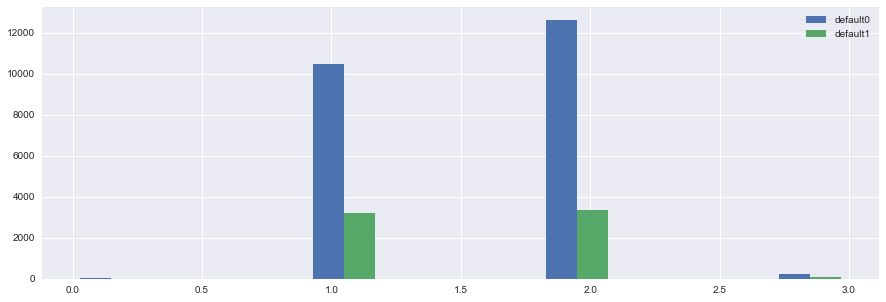

In [178]:
plt.figure(figsize=[15,5])
marriage0=df[df.default==0]['MARRIAGE'].values
marriage1=df[df.default==1]['MARRIAGE'].values
plt.hist((marriage0,marriage1), label=['default0', 'default1'])
plt.legend()
plt.show()

### 4.3 Корреляция

In [182]:
# Матрица сопряженности
r1=[np.sum(marriage0==m) for m in [0,1,2,3]]
r2=[np.sum(marriage1==m) for m in [0,1,2,3]]
cm=np.array([r1,r2])
cm

array([[   49, 10453, 12623,   239],
       [    5,  3206,  3341,    84]])

### 4.4 Проверим применимость критерия хи квадрат

In [183]:
sum(cm)

30000

In [192]:
np.sum([cm<5])

0

In [180]:
# хи квадрат
chi,p,t1,t2=chi2_contingency(cm)
p

8.8258624575773752e-08

In [181]:
# Коэффициент V крамера
n=len(marriage0)+len(marriage1)
np.sqrt(chi / (n*(2-1)))

0.034478203662766466

# Task 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

### 5.1 Выводы

пункт а
1. Построим доверительный интервал для разности медиан с помощью бутстрепа
2. Получаем CI=[0,1], 0 входит, поэтому однозначно сказать равны ли медианы нельзя.
3. Применим к выборке разности медиан Одновыборочный критерий Стьюдента
    * $H_0\colon$ среднее значение медианы разности равно 0. Т.е. медианы равны
    * $H_1\colon$ медианы не равны
4. p-value = 3.2937475166277854e-22
5. $H_0$ отвергается, т.е. медианы не равны

пункт б
1. Применим Перестановочный критерий для несвязанных выборок
    * $H_0$ - распределения равны
    * $H_1$ - распределения отличаются
2. p-value=p-value: 0.016000
3. На уровне значимости 0.05 $H_0$ отвергается
4. распределения отличаются

Вывод:Возраст влияет на возврат кредита

### 5.2 Визуализация

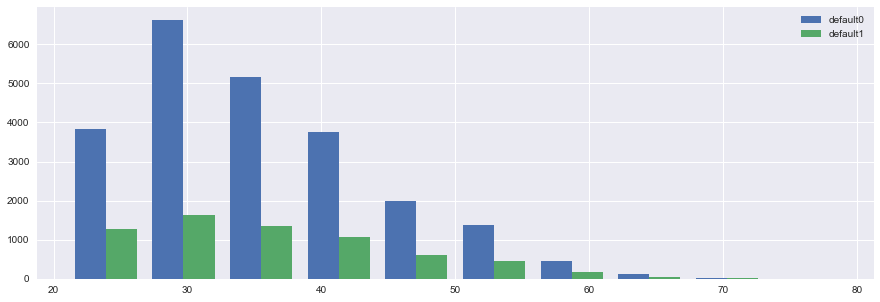

In [133]:
age0=df[df.default==0]['AGE'].values
age1=df[df.default==1]['AGE'].values
plt.figure(figsize=[15,5])

plt.hist((age0,age1), label=['default0', 'default1'])
plt.legend()
plt.show()

### 5.3 Проверка равенства медианных значений

In [134]:
np.random.seed(0)
# Получаем данные
# Формируем при помощт бутстрепа 1000 выборок 
n_boot=1000
age0_median_scores = list(map(np.median, get_bootstrap_samples(age0, 1000)))
age1_median_scores = list(map(np.median, get_bootstrap_samples(age1, 1000)))
# Интервальная оценка разности медиан
delta_median_scores = list(map(lambda x: x[1] - x[0], list(zip(age0_median_scores, age1_median_scores))))
print( "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [ 0.  1.]


In [135]:
stats.ttest_1samp(delta_median_scores, 0)

Ttest_1sampResult(statistic=9.9258389740775304, pvalue=3.2937475166277854e-22)

### 5.4 Перестановочный критерий для несвязанных выборок

In [136]:
print ("p-value: %f" % permutation_test(age0, age1, max_permutations =  2000))

23364 6636
p-value: 0.014500
